# Bibliography Visualisations
**Author:** Christian Byron  **Date:** 01-Aug-21

This notebook reads the bibliographic file `temp.bib` in the current directory and produces various graphs and tables to manage the references and readings

### Step 1 - Read the bibliography file 
Extract the useful information from the file and store in a new list of dictionarys of the following structure

`{Ref-String, DOI, Title, Year, authors}`

In [1]:
from pybtex.database import parse_file

file_data = parse_file('temp.bib')
bib = []
for ref in list(file_data.entries):
    entry_dict = {}
    entry_dict['Ref-string'] = ref
    entry = file_data.entries[ref]
    if "DOI" in list(entry.fields):
        entry_dict['DOI'] = entry.fields['DOI']
    else:
        entry_dict['DOI'] = ""
    entry_dict['Title'] = entry.fields['title']
    entry_dict['Year'] = int(entry.fields['year'])
    entry_dict['Authors'] = [str(author) for author in list(entry.persons['author'])]
    bib.append(entry_dict)

sort_key = lambda entry : entry['Year']
bib.sort(key=sort_key)

#print(bib[0])


### Step 2 - Retrieve additional citation data from Semantic Scholar

Add the following to the `bib` dictionary as available

`{'Abstract', 'Citations-DOI', 'Citations-Ref', 'References-DOI','References-Ref'}`

In [5]:
import semanticscholar as sch

papers = []
bib_doi = [entry['DOI'] for entry in bib]
bib_ref = [entry['Ref-string'] for entry in bib]

for entry in bib:
    DOI = entry['DOI']
    if DOI != "" :
        paper = sch.paper(DOI, timeout=2)
        entry['Abstract'] = paper.get('abstract','')
        citationsDOI = [citation['doi'] for citation in paper.get('citations',[])]
        entry['Citations-DOI'] = citationsDOI
        entry['Citations-Ref'] = []
        for DOI in citationsDOI :
            if DOI in bib_doi:
                ref = bib[bib_doi.index(DOI)]['Ref-string']
                entry['Citations-Ref'].append(ref)
        
        referencesDOI = [reference['doi'] for reference in paper.get('references',[])]
        entry['References-DOI'] = referencesDOI
        entry['References-Ref'] = []
        for DOI in referencesDOI :
            if DOI in bib_doi:
                ref = bib[bib_doi.index(DOI)]['Ref-string']
                entry['References-Ref'].append(ref)
        

print(bib[bib_ref.index('RN106')])

{'Ref-string': 'RN106', 'DOI': '10.1007/s11633-020-1258-8', 'Title': 'A Comprehensive Review of Group Activity Recognition in Videos', 'Year': 2021, 'Authors': ['Wu, Li-Fang', 'Wang, Qi', 'Jian, Meng', 'Qiao, Yu', 'Zhao, Bo-Xuan'], 'Abstract': 'Human group activity recognition (GAR) has attracted significant attention from computer vision researchers due to its wide practical applications in security surveillance, social role understanding and sports video analysis. In this paper, we give a comprehensive overview of the advances in group activity recognition in videos during the past 20 years. First, we provide a summary and comparison of 11 GAR video datasets in this field. Second, we survey the group activity recognition methods, including those based on handcrafted features and those based on deep learning networks. For better understanding of the pros and cons of these methods, we compare various models from the past to the present. Finally, we outline several challenging issues an

### Step 3 - Add user input data
Add the following to the `bib` dictionary as available

`{'Status', 'Approach', 'Datasets'}`

In [6]:
import json

data = json.load( open( "bib_added_data.json" ) )

for entry in data:
    ref = entry['Ref-string']
    if ref in bib_ref:
        bib[bib_ref.index(ref)].update(entry)

print(bib[bib_ref.index('RN121')])

{'Ref-string': 'RN121', 'DOI': '10.1109/cvpr.2019.01020', 'Title': 'Learning Actor Relation Graphs for Group Activity Recognition', 'Year': 2019, 'Authors': ['Wu, Jianchao', 'Wang, Limin', 'Wang, Li', 'Guo, Jie', 'Wu, Gangshan', 'Soc, Ieee Comp'], 'Abstract': 'Modeling relation between actors is important for recognizing group activity in a multi-person scene. This paper aims at learning discriminative relation between actors efficiently using deep models. To this end, we propose to build a flexible and efficient {\\rm Actor Relation Graph} (ARG) to simultaneously capture the appearance and position relation between actors. Thanks to the Graph Convolutional Network, the connections in ARG could be automatically learned from group activity videos in an end-to-end manner, and the inference on ARG could be efficiently performed with standard matrix operations. Furthermore, in practice, we come up with two variants to sparsify ARG for more effective modeling in videos: spatially localized 

### Step 4 - Graph the results

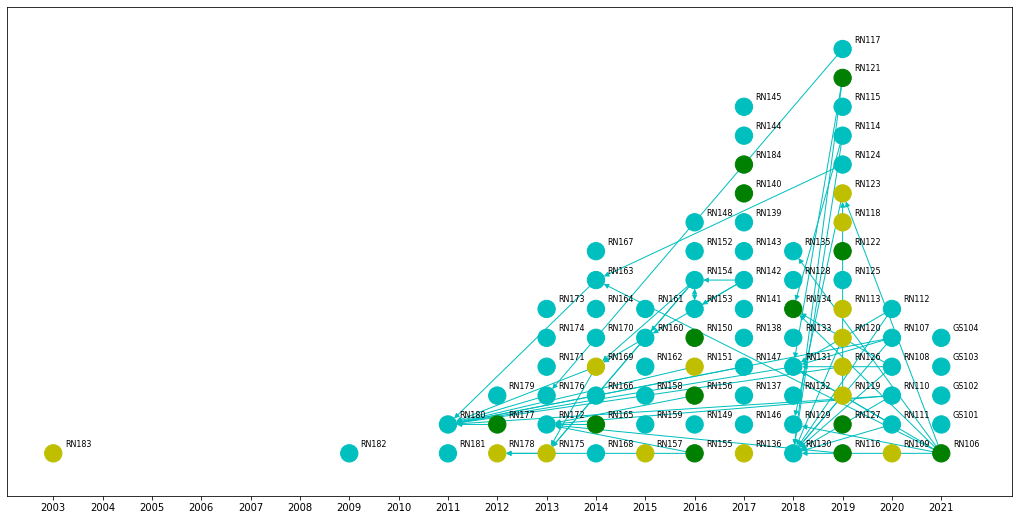

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

min_year = bib[0]['Year']
max_year = bib[-1]['Year']

G = nx.DiGraph()
colour_nodes =[]
status_colr_cd = {"Reviewed":"g", "In Review":"y", "None":"c"}

for ind_x, curr_year in enumerate(range(min_year,max_year+1)):
    curr_year_entries = [entry for entry in bib if entry['Year'] == curr_year]
    for ind_y, entry in enumerate(curr_year_entries):
        G.add_node(entry['Ref-string'],pos=(curr_year, ind_y * 60))
        colour = status_colr_cd[entry.get('Status', 'None')]
        colour_nodes.append(colour)
        
for entry in bib:
    for reference in entry.get('References-Ref',[]):
        G.add_edge(entry['Ref-string'],reference)

pos_nodes = nx.get_node_attributes(G,'pos')
pos_labels = nudge(pos_nodes, 0.5, 20)   

plt.figure(figsize=(18,9))
nx.draw_networkx(G, pos=pos_nodes, with_labels=False, edge_color='c', node_color=colour_nodes)
nx.draw_networkx_labels(G, pos=pos_labels, font_size =8)
plt.tick_params(bottom=True, labelbottom=True)
plt.xticks(range(min_year, max_year +1 , 1))
plt.show()

   ### Step 5 - Create the summary 

In [16]:
print("Total entries:{}".format(len(bib)))
print("Reviews Completed:{}".format(len([entry for entry in bib if entry.get('Status','') == 'Reviewed'])))
print("Reviewed Abstracts:{}".format(len([entry for entry in bib if entry.get('Status','') == 'In Review'])))

Total entries:83
Reviews Completed:13
Reviewed Abstracts:14


### Step 6 - Create the Abstract Table for Reading

In [4]:
from IPython.display import HTML, display

html_table_rows = ""
html_table_row = "<tr><td>{}</td><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr><tr><td colspan='5'>{}</td></tr>"

for entry in bib:
        abstract = entry.get('Abstract', '')
        citation_count = 0 if abstract == '' else len(entry['Citations-DOI'])
        html_table_rows += html_table_row.format(entry['Ref-string'], entry['Authors'][0], entry['Year'], 
                                                 entry['Title'], citation_count, abstract)
        

display(HTML("<table><tr><th>Ref</th><th>Author</th><th>Year</th><th>Title</th><th>Citation Count</th>" + 
             html_table_rows + "</table>"))